# Tutorial on Gaussian Processes

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

%matplotlib inline

## Definition of a Gaussian Process


A Gaussian Process defines a prior distribution over the space of all possible functions $f(\mathbf{x})$. They have the property that for any finite collection of points $\mathbf{x}$, the probability distribution over all of these points is from a multivariate Gaussian distribution.

A Gaussian Process is defined by a a mean $m(\mathbf{x})$ and a covariance function $k(\mathbf{x}, \mathbf{x}')$.

$$ f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}')) $$

Generally, the mean reflects the expected value at each point:

$$ m(\mathbf{x}) = \mathbb{E}[f(\mathbf{x})] $$

However, for convenience of inference it is best to set the mean to be zero everywhere:

$$ m(\mathbf{x}) = \mathbf{0} $$

[ 0.          0.11111111  0.22222222  0.33333333  0.44444444  0.55555556
  0.66666667  0.77777778  0.88888889  1.        ]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


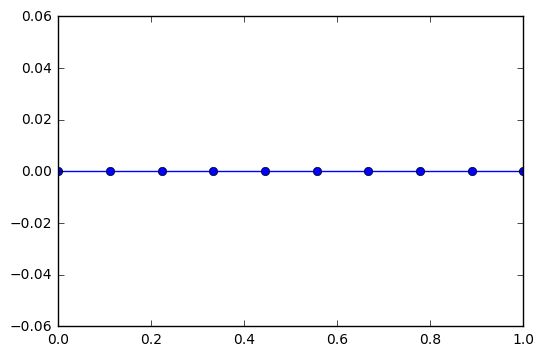

In [8]:
# create input data x
x = np.linspace(0, 1, 10)
print(x)

# create a zero mean vector
mean = np.zeros(len(x))
print(mean)

# plot the set of inputs points to pass into a GP later on
plt.plot(x, mean, '-o')

The covariance function represents the relationship or dependence between pairs of points in the input $\mathbf{x}$. There are many different possible covariance functions (they are required to be positive semi-definite), but are generally chosen such that they maintain some notion of *smoothness*. This notion of smoothness states that if points in the input $\mathbf{x}$ and $\mathbf{x'}$ are close together, then the outputs of the function $f(\mathbf{x})$ and $f(\mathbf{x'})$ should be similar in value, so $k(\mathbf{x}, \mathbf{x}')$ should be high and close to 1. On the other hand, if $\mathbf{x}$ and $\mathbf{x'}$ are far apart in the input space, then there should be little relationship between their outputs, and $k(\mathbf{x}, \mathbf{x}')$ should be close to 0. The covariance function is also often known as the *kernel*, and for the rest of this we examine one kind of kernel called the squared exponential kernel that encodes this assumption of smoothness.

## The squared exponential kernel

The squared exponential kernel (also known as the radian basis function kernel) is defined as follows:

$$k(\mathbf{x}, \mathbf{x}') = \sigma^2_f \exp(-\frac{\lVert \mathbf{x} - \mathbf{x}'\lVert}{2w^2})$$

It has two parameters, $\sigma_f$ which controls the variance of the output from a GP and $w$ (also known as the length-scale) which controls the distance at which points are relatively smooth.

Here is a function in Python that evaluates this kernel at two different points:

In [29]:
# define squared exponential kernel
def squared_exp_kernel(x1, x2, w=1, sigma=1):
    return (sigma ** 2) * np.exp(-1 * np.square(x1 - x2) / (2 * (w ** 2)))

Here is a plot of the squared exponential kernel, where I set $\mathbf{x} = 0$ and $\mathbf{x}'$ to take on different values from $-5$ to $5$ to show how $k(\mathbf{x}, \mathbf{x}')$ varies across different inputs, where it takes a maximum of 1 when $\mathbf{x}$ and $\mathbf{x}'$ are the same, and decreases as $\mathbf{x}'$ is further away from $\mathbf{x}$.

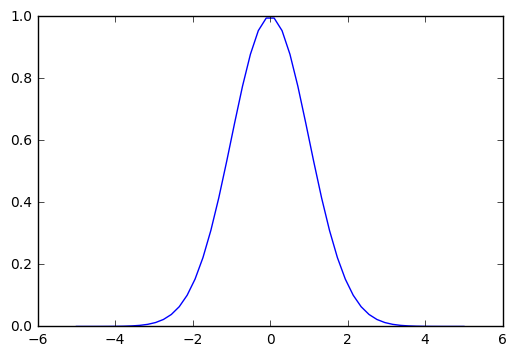

In [66]:
# plot of the squared exponential kernel
x1 = 0
x2 = np.linspace(-5, 5, 50)

k_x1x2 = squared_exp_kernel(x1, x2)
plt.plot(x2, k_x1x2)

## The covariance matrix

Having chosen an appropriate kernel, we just need one more ingredient in order to sample functions from a GP prior. Given an set of inputs $\mathbf{x}$, we define a covariance matrix with the equation below which calculates the kernel evaluated between every pair of points in $\mathbf{x}$ and places them in an $n \times n$ matrix.

$$ 
K_{\mathbf{X}_*, \mathbf{X}_*} = 
 \begin{bmatrix}
  k(\mathbf{x}^*_1, \mathbf{x}^*_1) & k(\mathbf{x}^*_1, \mathbf{x}^*_2) & \cdots & k(\mathbf{x}^*_1, \mathbf{x}^*_n) \\
  k(\mathbf{x}^*_2, \mathbf{x}^*_1) & k(\mathbf{x}^*_2, \mathbf{x}^*_2) & \cdots & k(\mathbf{x}^*_2, \mathbf{x}^*_n) \\
  \vdots  & \vdots  & & \vdots  \\
  k(\mathbf{x}^*_n, \mathbf{x}^*_1) & k(\mathbf{x}^*_n, \mathbf{x}^*_2) & \cdots & k(\mathbf{x}^*_n, \mathbf{x}^*_n) 
 \end{bmatrix} 
 $$

In [31]:
# create a covariance matrix based off the squared exponential kernel
def cov_matrix(x, w=1, sigma=1):
    n = len(x) # number of data points
    K = np.empty([n, n]) # initialize empty square covariance matrix of size n
    
    # loop over each entry in the matrix and evaluate 
    # each pair of data points with the kernel function
    for i in range(n):
        for j in range(n):
            K[i, j] = squared_exp_kernel(x[i], x[j], w, sigma)
        
    # return the filled in covariance matrix
    return K

In [32]:
# creating a covariance matrix with n input points
n = 5
x = np.linspace(0, 1, n)
cov = cov_matrix(x)
print(cov)

[[ 1.          0.96923323  0.8824969   0.7548396   0.60653066]
 [ 0.96923323  1.          0.96923323  0.8824969   0.7548396 ]
 [ 0.8824969   0.96923323  1.          0.96923323  0.8824969 ]
 [ 0.7548396   0.8824969   0.96923323  1.          0.96923323]
 [ 0.60653066  0.7548396   0.8824969   0.96923323  1.        ]]


## Sampling functions from a GP

Now, given a mean $m(\mathbf{x}) = 0$ and a covariance matrix $K(\mathbf{X}_*, \mathbf{X}_*)$, sampling a function merely involves sampling from a multivariate Gaussian distribution with the mean and covariance function as the parameters of the distribution, i.e.: 

$$ \mathbf{f}_* \sim \mathcal{N}(\mathbf{0}, K(\mathbf{X}_*, \mathbf{X}_*)) $$

Below, I show how this can implemented in Python:

//anaconda/envs/py35/lib/python3.5/site-packages/scipy/stats/_multivariate.py:533: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


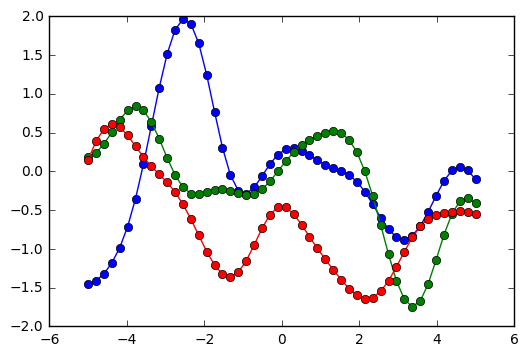

In [65]:
# sample function from a GP
def GP(x, w=1, sigma=1):
    mean = np.zeros(len(x)) # create zero mean vector
    cov = cov_matrix(x, w, sigma) # create covariance matrix with squared exp kernel
    y = multivariate_normal.rvs(mean = mean, cov = cov) # sample from a GP
    return y

# sample functions from a GP
x = np.linspace(-5, 5, 50) # input vector
y1 = GP(x)
y2 = GP(x)
y3 = GP(x)

# plot functions
plt.plot(x, y1, '-o')
plt.plot(x, y2, '-o')
plt.plot(x, y3, '-o')

## Varying the length and variance parameters of the squared exponential kernel

//anaconda/envs/py35/lib/python3.5/site-packages/scipy/stats/_multivariate.py:533: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


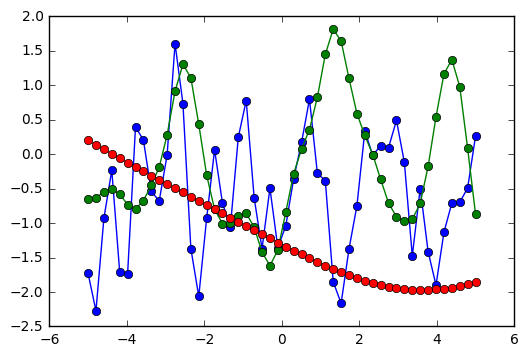

In [52]:
# varying the length parameter
x = np.linspace(-5, 5, 50) # input vector
y1 = GP(x, w = 1/5)
y2 = GP(x, w = 1/2)
y3 = GP(x, w = 5)

# plot functions
plt.plot(x, y1, '-o')
plt.plot(x, y2, '-o')
plt.plot(x, y3, '-o')

//anaconda/envs/py35/lib/python3.5/site-packages/scipy/stats/_multivariate.py:533: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


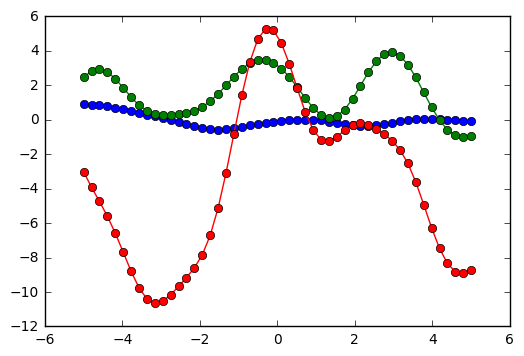

In [55]:
# varying the variance parameter
x = np.linspace(-5, 5, 50) # input vector
y1 = GP(x, sigma = 1/3)
y2 = GP(x, sigma = 2)
y3 = GP(x, sigma = 5)

# plot functions
plt.plot(x, y1, '-o')
plt.plot(x, y2, '-o')
plt.plot(x, y3, '-o')

## Posterior predictives from a GP

How can we condition on some observed data points, such that functions drawn from the posterior pass through the observed data points?